## Prepossessing

In [1]:
import sys

print ("Initializing global variables...", end=' ')
sys.stdout.flush()

# Filepaths
dict_path = "../dictionaries/"
model_path = "../models/"
hist_path = "../histories/"
fig_path = "../figs/"

print ("Done")

Initializing global variables... Done


In [2]:
print ("Hooking notebook finder...", end=' ')
sys.stdout.flush()

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

# Loader
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        # print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

# Finder
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

print ("Done")

Hooking notebook finder... Done


In [3]:
print ("Importing custom modules...", end=' ')
import Modules
print ("Done")

Importing custom modules... 

Using TensorFlow backend.


Done


In [4]:
print ("Reading data from disk...", end=' ')
sys.stdout.flush()

import numpy as np
import pandas as pd

df = pd.read_parquet('../Metal_all_20180116.snappy.parquet')
# print ('***** Data Types *****' + '\n' + str(df.dtypes) + '\n\n' + 
#        '***** Unique Ligands *****' + '\n' + str(df.ligandId.unique()))

# Extract zinc-binded, single-chained protein sequences
df_zn = df.loc[df['ligandId'] == 'ZN']
df_zn_single = df_zn.loc[df_zn['interactingChains'] == 1]
seqs = np.array(df_zn_single.sequence)
target = np.array(df_zn_single.fingerprint)

del df,df_zn,df_zn_single

# Remove seqs containing 'U' and 'X'
rows_to_delete = []
for i in range(seqs.shape[0]):
    if 'X' in seqs[i] or 'U' in seqs[i]:
#         print('Removing...' + str(i))
        rows_to_delete.append(i)        
        
seqs = np.delete(seqs, rows_to_delete, 0)
target = np.delete(target, rows_to_delete)
print ("Done")
# print ("Sequence length is " + str(seqs.shape[0]))

Reading data from disk... Done


In [5]:
print ("Performing cross validation split...", end=' ')
ratio = 0.9
split = int(ratio*len(seqs))
train_seqs, val_seqs = seqs[:split], seqs[split:]
train_label, val_label = target[:split], target[split:]
print ("Done")
print ("  Ratio :", ratio)
print ("  Train_range :", 0, "-", split-1)
print ("  Val_range :", split, "-", len(seqs)-1)

Performing cross validation split... Done
  Ratio : 0.9
  Train_range : 0 - 20504
  Val_range : 20505 - 22783


In [6]:
print ("Loading dictionaries...", end=' ')
sys.stdout.flush()

# Load
seqs_dict_w2v = {}
with open(dict_path + "seq_n_gram_to_vec_dict_w_UX", 'r') as fp:
        seqs_dict_w2v = json.load(fp)

seqs_dict_onehot = {}
with open(dict_path + "seqs_dict_onehot", 'r') as fp:
        seqs_dict_onehot = json.load(fp)
        
print ("Done")

Loading dictionaries... Done


## Data Generator

- <font color=blue>One-hot Encoding</font>

In [7]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_dict_onehot}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_dict_onehot}
common_args = {'batch_size': 100,
               'input_shape': (706, 20),
               'label_shape': (706, 1),
               'shuffle': True}

In [8]:
train_gen = Modules.OneHotGenerator(**train_args, **common_args)
val_gen = Modules.OneHotGenerator(**val_args, **common_args)

- <font color=blue>ProtVec Encoding</font>

In [7]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_dict_w2v}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_dict_w2v}
common_args = {'batch_size': 100,
               'input_shape': (706, 100),
               'label_shape': (706, 1),
               'shuffle': True}

In [8]:
train_gen = Modules.ProtVecGenerator(**train_args, **common_args)
val_gen = Modules.ProtVecGenerator(**val_args, **common_args)

## Model
- <font color=blue>Single BRNN</font>

In [9]:
from keras.layers import LSTM, Dense,Dropout, TimeDistributed, Bidirectional, Input, Concatenate, Flatten
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
# Visualization
from keras.utils import plot_model

input_shape = (706, 100)
lstm_size = 64

input_0 = Input(shape=input_shape)
bd_lstm_0 = Bidirectional(LSTM(lstm_size, return_sequences=True), 
                          input_shape=input_shape, 
                          merge_mode='ave')(input_0)      
do_0 = Dropout(0.2)(bd_lstm_0)
output_0 = TimeDistributed(Dense(1, activation='tanh'))(do_0)

optimizer = SGD(lr=0.001, momentum=0.95)
model = Model(inputs=input_0, outputs=output_0)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
# model.summary()

<img src="../figs/single_brnn.png">

- <font color=blue>Threshold: mean+3*std</font>

In [10]:
def threshold_func(y_in):
    factor = 3
    y_out = np.zeros_like(y_in)
    for i in range(y_in.shape[0]):
        th= np.mean(y_in[i]) + factor * np.std(y_in[i])
        y_out[i] = (y_in[i] > th)
    return y_out

- <font color=blue>Metric: F1 score</font>

In [11]:
cb = Modules.F1_history(threshold_func)

Callback initialized.


In [12]:
model_args = {'model': model, 
              'generators': [train_gen, val_gen], 
              'callbacks': [cb]}

In [13]:
trainer = Modules.Trainer(**model_args)

Assigning validation generator... Done
Matching input shape... Done
Matching output shape... Done
Trainer initialized.


In [14]:
trainer.start(epoch=10)

Epoch 1/10
205/205 [==============================] - 427s 2s/step - loss: 0.0601
Epoch 2/10
205/205 [==============================] - 422s 2s/step - loss: 0.0768
Epoch 3/10
205/205 [==============================] - 422s 2s/step - loss: 0.0498
Epoch 4/10
205/205 [==============================] - 422s 2s/step - loss: 0.0485
Epoch 5/10
205/205 [==============================] - 422s 2s/step - loss: 0.0447
Epoch 6/10
205/205 [==============================] - 421s 2s/step - loss: 0.0581
Epoch 7/10
205/205 [==============================] - 422s 2s/step - loss: 0.0419
Epoch 8/10
205/205 [==============================] - 425s 2s/step - loss: 0.0397
Epoch 9/10
205/205 [==============================] - 424s 2s/step - loss: 0.0391
Epoch 10/10
205/205 [==============================] - 429s 2s/step - loss: 0.0381
[End of Training]


## Visualization

In [15]:
with open(hist_path + "sgbrnn_w2v_adam_10", 'w') as fp:
        json.dump(cb.f1_scores, fp)
model.save(model_path + "sgbrnn_w2v_adam_10")

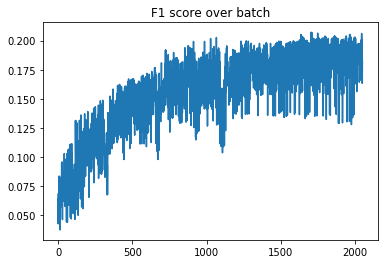

In [16]:
history_of_f1s = []
# for i in range(30):
#     history_of_f1s.append(np.average(np.array(cb.f1_scores[i*205:(i+1)*205])))

import matplotlib.pyplot as plt
fig = plt.figure(0)
ax = fig.add_subplot(111)
ax.set_title('F1 score over batch')
ax.plot(cb.f1_scores)
fig.canvas.draw()
plt.show()
# plt.savefig(fig_path + "sgbrnn_oh_adam_31.png")

In [ ]:
plot_model(model, to_file= fig_path + 'single_brnn.png', show_shapes=True)